<a href="https://colab.research.google.com/github/BaranidharanB/Point-Cloud-Classification-PointNet-Deep-Learning/blob/main/Point_Cloud_Classification_PointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install trimesh
import os
import glob
import trimesh
import trimesh
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(1234)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 5.7 MB/s eta 0:00:00


In [8]:
tf.random.set_seed(1234)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPU's available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

GPU's available:  1


In [9]:
Data = tf.keras.utils.get_file(
  "modelnet.zip",
  "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
      extract = True
  )
Data = os.path.join(os.path.dirname(Data),"ModelNet10")

473402300/473402300 [==============================] - 6s 0us/step


In [10]:
# Adding the training data of the object
Mesh = trimesh.load(os.path.join(Data,"table/train/table_0330.off"))
Mesh.show()

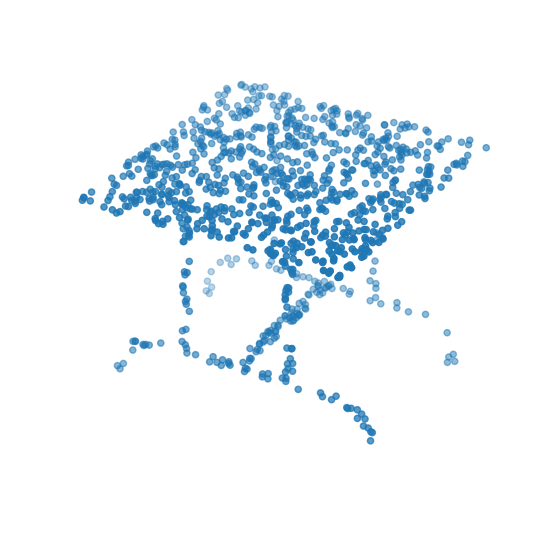

In [11]:
Points = Mesh.sample(1024)
Figure = plt.figure(figsize = (7,7))
ax = Figure.add_subplot(111,projection='3d')
ax.scatter(Points[:,0],Points[:,1],Points[:,2])
ax.set_axis_off()
plt.show()

In [12]:
# The generated mesh and pointcloud will be stored as a numpy array
def ParseDataset (Numpoints = 1024):

  TrainPoints =[]
  TrainLabels =[]
  TestPoints =[]
  TestLabels = []
  ClassMap ={}
  Folders = glob.glob(os.path.join(Data,"[!README]*"))

  for i, Folder in enumerate (Folders):

    print("Processing Class: {}".format(os.path.basename(Folder)))

    # Storing the folder name to retrieve later
    ClassMap[i] = Folder.split("/")[-1]
    TrainFiles =glob.glob(os.path.join(Folder,"train/*"))
    TestFiles =glob.glob(os.path.join(Folder,"test/*"))

    for j in TrainFiles:
      TrainPoints.append(trimesh.load(j).sample(Numpoints))
      TrainLabels.append(i)

    for j in TestFiles:
      TestPoints.append(trimesh.load(j).sample(Numpoints))
      TestLabels.append(i)

  return (
      np.array(TrainPoints),
      np.array(TestPoints),
      np.array(TrainLabels),
      np.array(TestLabels),
      ClassMap,
  )




In [13]:
NumPoints = 1024
NumClasses = 10
BatchSize = 32

TrainPoints,TestPoints,TrainLabels,TestLabels,ClassMap = ParseDataset(NumPoints)

Processing Class: toilet
Processing Class: night_stand
Processing Class: monitor
Processing Class: chair
Processing Class: dresser
Processing Class: bed
Processing Class: table
Processing Class: sofa
Processing Class: desk
Processing Class: bathtub


In [14]:
# Augmenting for Training Dataset
def Augment (Points, Label):
  Points += tf.random.uniform(Points.shape,-0.005,0.005,dtype = tf.float64)
  Points = tf.random.shuffle(Points)
  return Points, Label

TrainDataset = tf.data.Dataset.from_tensor_slices((TrainPoints,TrainLabels))
TestDataset = tf.data.Dataset.from_tensor_slices((TestPoints,TestLabels))

TrainDataset = TrainDataset.shuffle(len(TrainPoints)).map(Augment).batch(BatchSize)
TestDataset = TestDataset.shuffle(len(TestPoints)).map(Augment).batch(BatchSize)




In [15]:
# Function to build the model

def Conv(x,filters):
  x = layers.Conv1D(filters,kernel_size = 1,padding = "valid")(x)
  x = layers.BatchNormalization(momentum = 0.0)(x)
  return layers.Activation("relu")(x)

def dense(x,filters):
  x = layers.Dense(filters)(x)
  x = layers.BatchNormalization(momentum = 0.0)(x)
  return layers.Activation("relu")(x)

In [29]:
class OrthogonalRegulizer (keras.regularizers.Regularizer):
  def __init__ (self,numFeatures,l2reg = 0.001):
    self.numFeatures = numFeatures
    self.l2reg = l2reg
    self.eye = tf.eye(numFeatures)

  def __call__(self,x):
    x = tf.reshape(x,(-1,self.numFeatures,self.numFeatures))
    xtt = tf.tensordot(x,x,axes = (2,2))
    xtt = tf.reshape(xtt,(-1,self.numFeatures,self.numFeatures))
    return tf.reduce_sum(self.l2reg * tf.square(xtt - self.eye))


In [30]:
# Function for creating T-Net Layers
# This function takes care of the affin transformation of the point cloud values in the array

def TNet(inputs,numFeatures):

  # Initializing bias as Identity matrix
  Bias = keras.initializers.Constant(np.eye(numFeatures).flatten())
  Reg = OrthogonalRegulizer(numFeatures)

  x = Conv(inputs,32)
  x = Conv (x,64)
  x = Conv (x,512)
  x = layers.GlobalMaxPooling1D()(x)
  x = dense (x,256)
  x = dense (x,128)

  x = layers.Dense(numFeatures * numFeatures, kernel_initializer = "zeros",
                   bias_initializer = Bias,activity_regularizer = Reg)(x)

  FeatT = layers.Reshape((numFeatures,numFeatures))(x)

  # Applying Affine Transformation in input features
  return layers.Dot(axes=(2,1))([inputs,FeatT])





In [31]:
# Creating the Convolutional Neural Network
inputs = keras.Input(shape=(NumPoints,3))

x = TNet(inputs,3)
x = Conv(x,32)
x = Conv(x,32)
x = TNet(x,32)
x = Conv (x,32)
x = Conv (x,64)
x = Conv (x,512)
x = layers.GlobalMaxPooling1D()(x)
x = dense (x,256)
x = layers.Dropout(0.3)(x)
x = dense (x,128)
x = layers.Dropout(0.3)(x)

Outputs = layers.Dense(NumClasses,activation = "softmax")(x)

Model = keras.Model(inputs=inputs,outputs = Outputs, name = "pointnet")
Model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 1024, 32)     128         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 1024, 32)    128         ['conv1d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 1024, 32)     0           ['batch_normalization_27[0

In [32]:
# Compiling and training the model
Model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["sparse_categorical_accuracy"],

)

Model.fit(TrainDataset,epochs = 10,validation_data =  TestDataset)

Epoch 1/10
125/125 [==============================] - 26s 88ms/step - loss: 3.5165 - sparse_categorical_accuracy: 0.2806 - val_loss: 76882.8359 - val_sparse_categorical_accuracy: 0.2313
Epoch 2/10
125/125 [==============================] - 11s 87ms/step - loss: 3.0428 - sparse_categorical_accuracy: 0.3578 - val_loss: 2379050147056508207104.0000 - val_sparse_categorical_accuracy: 0.2919
Epoch 3/10
125/125 [==============================] - 11s 89ms/step - loss: 2.8352 - sparse_categorical_accuracy: 0.4422 - val_loss: 3669652603246582169600.0000 - val_sparse_categorical_accuracy: 0.3789
Epoch 4/10
125/125 [==============================] - 11s 86ms/step - loss: 2.5774 - sparse_categorical_accuracy: 0.5390 - val_loss: 26012289296333533085696.0000 - val_sparse_categorical_accuracy: 0.4108
Epoch 5/10
125/125 [==============================] - 11s 86ms/step - loss: 2.3528 - sparse_categorical_accuracy: 0.6069 - val_loss: 6.5578 - val_sparse_categorical_accuracy: 0.4703
Epoch 6/10
125/125 [==

1/1 [==============================] - 1s 996ms/step


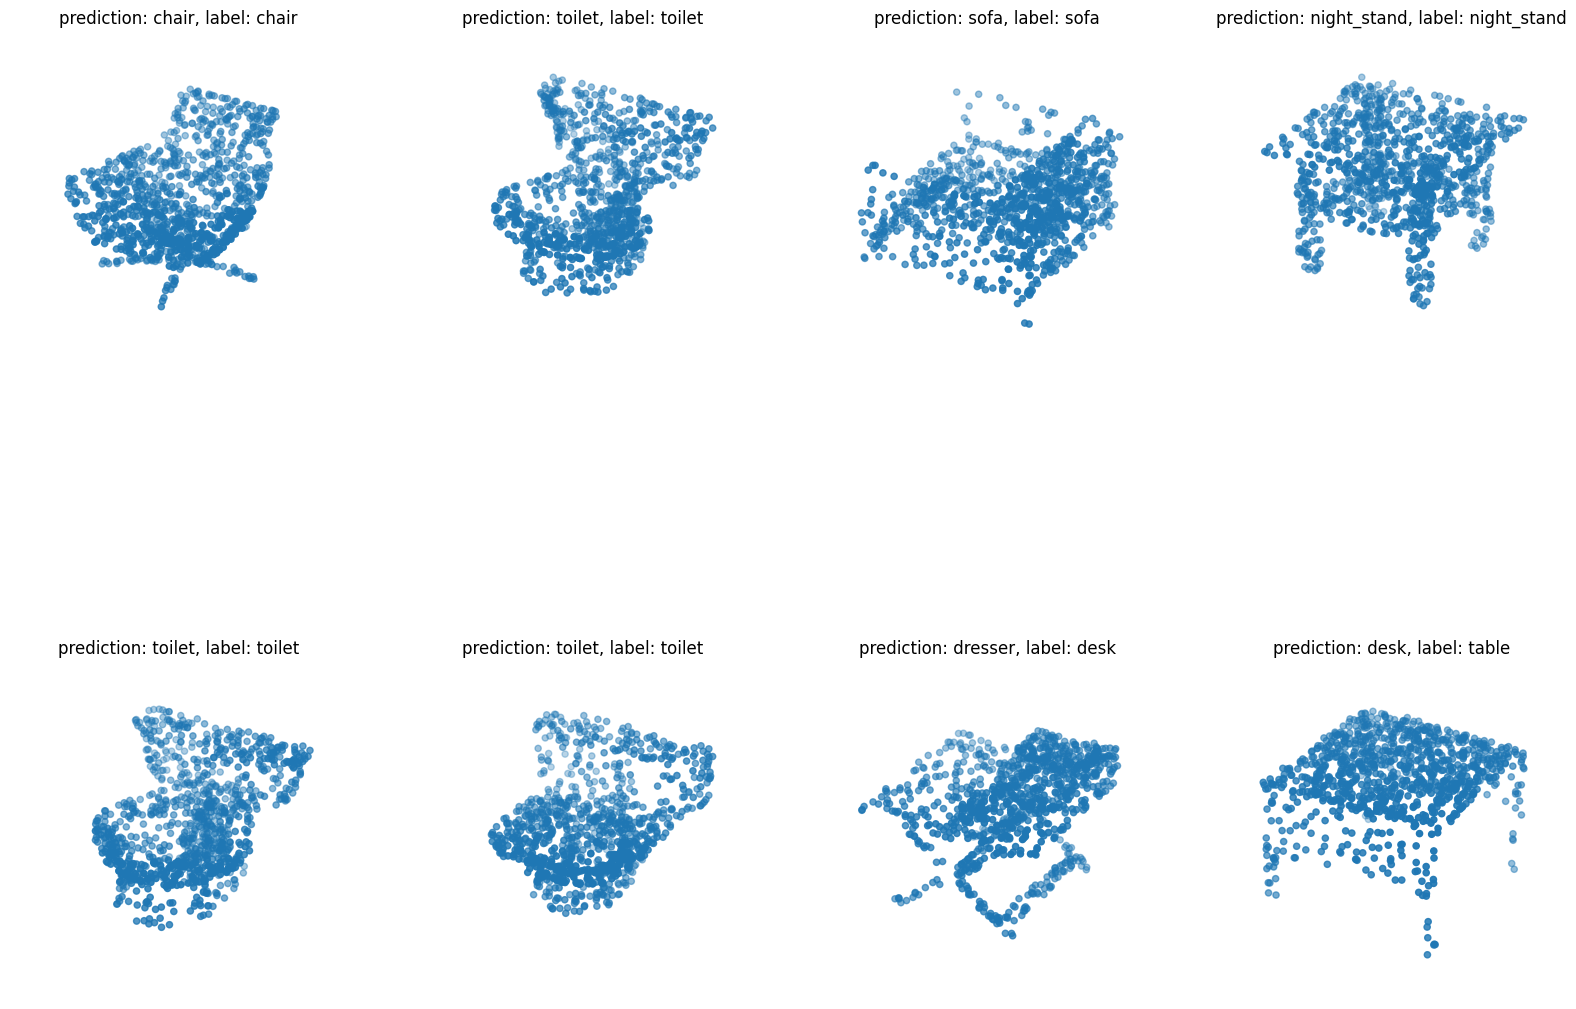

In [33]:
# Visualizing

Data = TestDataset.take(1)

Points, Labels = list(Data)[0] # Taking few samples from the data
Points = Points[:8,...]
Labels = Labels[:8,...]

# Running Test data
Predictions = Model.predict(Points)
Predictions = tf.math.argmax(Predictions,-1)

Points = Points.numpy()

# Plotting points with predicted classes and labels

Fig = plt.figure(figsize=(20,15))
for i in range(8):
  ax = Fig.add_subplot(2,4, i+1, projection = "3d")
  ax.scatter(Points[i, :, 0], Points[i, :, 1], Points[i, :, 2])
  ax.set_title(
    "prediction: {:}, label: {:}".format(
        ClassMap[Predictions[i].numpy()],ClassMap[Labels.numpy()[i]]
    )
  )
  ax.set_axis_off()
plt.show()

